# Color Extractor to Form Clusters for the Different Colors

In [1]:
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import tensorflow as tf
import webcolors

from datetime import datetime
from io import BytesIO
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image, ImageDraw
from Pylette.src.color import Color
from Pylette.src.palette import Palette
from Pylette.src.utils import ColorBox
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.preprocessing import image


### Code to Get Color

In [2]:
def k_means_extraction(arr, height, width, palette_size):
    arr = np.reshape(arr, (width * height, -1))
    model = KMeans(n_clusters=palette_size, n_init="auto", init="k-means++")
    labels = model.fit_predict(arr)
    palette = np.array(model.cluster_centers_, dtype=int)
    color_count = np.bincount(labels)
    color_frequency = color_count / float(np.sum(color_count))
    colors = []
    for color, freq in zip(palette, color_frequency):
        # Check if the alpha channel is not small
        if color[3] > 20 and not is_white(color[0], color[1], color[2]):
            colors.append(Color(color, freq))
    return colors

def median_cut_extraction(arr, height, width, palette_size):
    arr = arr.reshape((width * height, -1))
    c = [ColorBox(arr)]
    full_box_size = c[0].size

    while len(c) < palette_size:
        largest_c_idx = np.argmax(c)
        c = c[:largest_c_idx] + c[largest_c_idx].split() + c[largest_c_idx + 1 :]

    colors = [Color(map(int, box.average), box.size / full_box_size) for box in c if np.any(box.average[3] != 0)]

    return colors

def is_white(r, g, b):
    white = (254, 254, 254)
    threshold = 10
    if (abs(r - white[0]) <= threshold and
        abs(g - white[1]) <= threshold and
        abs(b - white[2]) <= threshold):
        return True
    else:
        return False

def extract_colors(
    image=None,
    image_url: str = None,
    palette_size=5,
    resize=True,
    mode="KM",
    sort_mode=None,
):
    if image is None and image_url is None:
        raise ValueError("No image provided")

    if image is None and image_url is not None:
        response = requests.get(image_url)
        if response.status_code == 200 and "image" in response.headers.get(
            "Content-Type", ""
        ):
            img = Image.open(BytesIO(response.content)).convert("RGBA")
        else:
            raise ValueError("The URL did not point to a valid image.")
    else:
        img = Image.open(image).convert("RGBA")

    if resize:
        img = img.resize((256, 256))
    width, height = img.size
    arr = np.asarray(img)

    if mode == "KM":
        colors = k_means_extraction(arr, height, width, palette_size)
    elif mode == "MC":
        colors = median_cut_extraction(arr, height, width, palette_size)
    else:
        raise NotImplementedError("Extraction mode not implemented")

    if sort_mode == "luminance":
        colors.sort(key=lambda c: c.luminance, reverse=False)
    else:
        colors.sort(reverse=True)

    return Palette(colors)

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour[:3])
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

requested_colour = (119, 172, 152)


In [3]:
def display_color_palette(image_path, square_size=100):
    # Load in clothing image
    clothing_img = Image.open(image_path).convert("RGB")
    clothing_img_resized = clothing_img.resize((square_size, square_size))

    # Extract most common colors for palette values
    palette_size = 10
    palette = extract_colors(image=image_path, palette_size=3, resize=True)
    colors = [color.rgb for color in palette]

    # Calculate the dimensions of the image based on the number of colors
    num_colors = len(colors)
    
    palette_width = square_size * num_colors
    palette_height = square_size
    
    # Create a new image with a white background
    palette_img = Image.new("RGB", (palette_width, palette_height), color="white")
    draw = ImageDraw.Draw(palette_img)
    
    # Draw squares for each color
    color_names = []
    for i, color in enumerate(colors):
        x0 = i * square_size
        y0 = 0
        x1 = x0 + square_size
        y1 = y0 + square_size

        # Get color names
        _, color_name = get_colour_name(color)
        color_names.append(color_name)

        draw.rectangle([x0, y0, x1, y1], fill=tuple(color))
    
    # Concatenate the images horizontally
    combined_img = Image.new("RGB", (square_size * (num_colors + 1), palette_img.height))
    combined_img.paste(clothing_img_resized, (0, 0))
    combined_img.paste(palette_img, (clothing_img_resized.width, 0))
    
    # Display the combined image
    display(combined_img)

    return color_names

def get_color(image_path):
    palette = extract_colors(image=image_path, palette_size=3, resize=True)
    return palette[0].rgb[:3]

### Example as Sanity Check with Palette

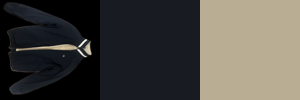

['black', 'darkgray']


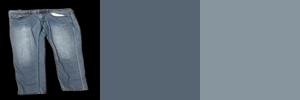

['dimgray', 'lightslategray']


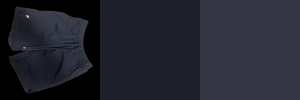

['black', 'darkslategray']


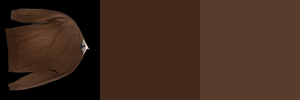

['darkslategray', 'darkolivegreen']


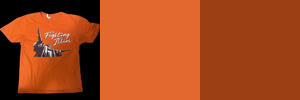

['chocolate', 'saddlebrown']


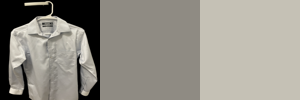

['gray', 'silver']


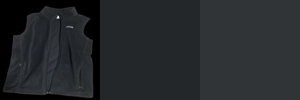

['darkslategray', 'darkslategray']


In [4]:
# Loop through all images
input_path = "/Users/josephkuang/Desktop/CS 525/data/no_background_images"
for filename in sorted(os.listdir(input_path)):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(input_path, filename)
        colors = display_color_palette(image_path)
        print(colors)


### Get Color Points

In [7]:
import os
import csv
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

folder_path = "../polyvore_outfits/images/"
output_file = "filename_to_color.csv"
files = sorted(os.listdir(folder_path))
print("Number of images:", len(files))

filename_to_color = {}
num_cores = 4

# Define a function to process each image
def process_image(filename):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(folder_path, filename)
        return filename, get_color(image_path)

# Create a tqdm progress bar
with tqdm(total=len(files), desc="Processing images") as pbar:
    with ThreadPoolExecutor(max_workers=num_cores) as executor:
        # Process images concurrently
        futures = [executor.submit(process_image, filename) for filename in files]
        for future in futures:
            result = future.result()
            if result:
                filename_to_color[result[0]] = result[1]
                pbar.update(1)  # Update progress bar

# Write the results to CSV
with open(output_file, "w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Filename", "r", "g", "b"])  # Write header row
    for filename, color in filename_to_color.items():
        writer.writerow([filename, color[0], color[1], color[2]])

print("Map saved to:", output_file)


Number of images: 252080


Processing images:   0%|          | 0/252080 [00:00<?, ?it/s]

### Get Color Clusters

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


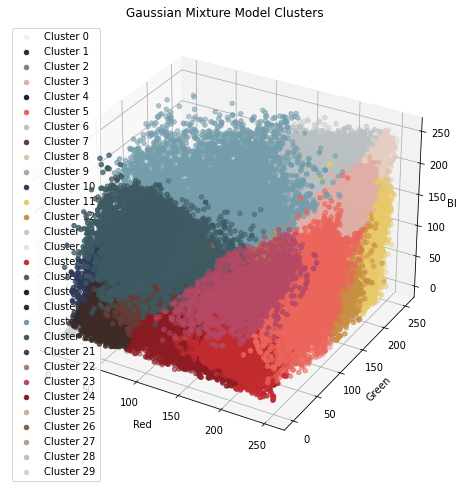

In [5]:
# Read data from CSV file
df = pd.read_csv('filename_to_color.csv')

# Extract RGB values
X = df[['r', 'g', 'b']].values

# Fit Gaussian Mixture Model
clusters = 30
gmm = GaussianMixture(n_components=clusters, random_state=42)
gmm.fit(X)

# Predict cluster labels
cluster_means = gmm.means_

labels = gmm.predict(X)

# Visualize clusters in 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.tab20(np.linspace(0, 1, clusters))

# Scatter plot for each cluster with a distinct color
for cluster, color in zip(range(clusters), cluster_means):
    cluster_points = X[labels == cluster]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], c=[color / 255], label=f'Cluster {cluster}')

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('Gaussian Mixture Model Clusters')
ax.legend()
plt.show()


### Get Save Clusters

In [6]:
# Retrieve item cluster assignment
file = open('../polyvore_outfits/item_metadata.json', 'r')
items_map = json.load(file)

file = open('../polyvore_outfits/local_category_map.json', 'r')
mapping = json.load(file)

header = ['id', 'category', 'group']
categories = pd.read_csv('../polyvore_outfits/categories.csv', names=header, header=None)

In [29]:
reverse_mapping = {str(type_id) : -1 for type_id in categories["id"]}
for local_key, data in mapping.items():
    keys = data["mapping"]
    for server_key in keys:
        reverse_mapping[str(server_key)] = local_key

print(reverse_mapping)

category_ids, detail = [], []
for filename in df['Filename']:
    if filename[:-4] in items_map:
        category_ids.append(reverse_mapping[items_map[filename[:-4]]["category_id"]])
        detail.append(items_map[filename[:-4]]["semantic_category"])
    else:
        category_ids.append(-2)
        detail.append("NA")

{'2': -1, '3': '2', '4': '2', '5': '2', '6': '2', '7': '0', '8': '0', '9': '0', '10': '0', '11': '12', '15': '7', '17': '7', '18': '10', '19': '12', '21': '3', '23': '1', '24': '1', '25': '1', '26': '10', '27': '9', '28': '4', '29': '8', '30': '13', '31': -1, '35': -1, '36': -1, '37': -1, '38': -1, '39': -1, '40': -1, '41': -1, '42': -1, '43': -1, '46': -1, '47': -1, '48': -1, '49': -1, '50': -1, '51': -1, '52': -1, '53': -1, '55': -1, '56': -1, '57': -1, '58': -1, '59': -1, '61': -1, '62': -1, '64': -1, '65': -1, '68': -1, '69': -1, '104': '5', '105': -1, '106': -1, '107': -1, '231': -1, '236': '13', '237': '9', '238': '9', '239': '9', '240': '9', '241': '4', '243': '11', '244': '6', '245': -1, '246': -1, '247': -1, '248': '4', '249': '4', '250': '7', '251': -1, '252': '3', '253': '4', '254': '0', '255': '8', '256': '1', '257': -1, '258': -1, '259': -1, '260': -1, '261': -1, '262': -1, '263': -1, '264': -1, '265': -1, '266': -1, '267': -1, '268': -1, '269': -1, '270': -1, '272': '3', 

In [32]:
# Save gmm model 
joblib.dump(gmm, 'gmm_color_model.pkl')

# Retrieve item cluster assignment

# Save cluster assignment
save_data = df[['Filename']].copy()  # Copy 'Filename' column
save_data['Color Cluster'] = labels  # Add 'Cluster' column
save_data['Category Id'] = category_ids
save_data['detail'] = detail
save_data.to_csv('filename_to_cluster.csv', index=False)


### Create Embeddings

In [101]:
gmm_color_model = joblib.load('gmm_color_model.pkl')

headers = ["Filename", "Color Cluster", "Category Id", "detail"]
clusters = pd.read_csv('filename_to_cluster.csv')

# 1) Count the number for each color and each category for division
color_cluster_counts = clusters['Color Cluster'].value_counts()
item_cluster_counts = clusters['Category Id'].value_counts()

In [118]:
# Half of the Inference Model Stored on Client Side
class ClientResNet(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(ClientResNet, self).__init__(*args, **kwargs)
        
        # Load ResNet50 pre-trained model without top (fully connected) layers
        resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        resnet_base.trainable = False
        
        # Get the output of the first three convolutional layers
        middle_layer = resnet_base.get_layer('conv3_block4_out')
        self.seq0 = Model(inputs=resnet_base.input, outputs=middle_layer.output)

    # Convert image into right dimensions
    def preprocess_image(self, img):
        img_array = kimage.img_to_array(img)
        expand_img = np.expand_dims(img_array, axis=0)
        return preprocess_input(expand_img)

    # Forward pass of the client model
    def predict(self, image_path):
        img = Image.open(image_path)
        img = img.resize((224, 224)).convert("RGB")

        preprocessed_img = self.preprocess_image(img)
        img.close()
        return self.seq0(preprocessed_img)
    
model = ClientResNet()

In [122]:
# 2) Create blanks for each of the categories
emb_dim = (1, 28, 28, 512)

color_centers = {}
for key, _ in color_cluster_counts.items():
    color_centers[key] = np.zeros(emb_dim)

item_centers = {}
for key, _ in item_cluster_counts.items():
    item_centers[key] = np.zeros(emb_dim)

# Paths
folder_path = "../polyvore_outfits/images/"
clusters['path'] = clusters['Filename'].apply(lambda x: os.path.join(folder_path, x))

start_time = datetime.now()
total_iterations = len(clusters)

# 3) Process images
for i, row in clusters.iterrows():
    path, color, item = row['path'], row['Color Cluster'], row['Category Id']

    # Make prediction
    embeddings = model.predict(path)
    
    # Add to color + embedding centers
    color_centers[color] += embeddings

    # Add to embedding center
    item_centers[item] += embeddings
    
    # Timer for estimates
    if i % 2500 == 0:
        elapsed_time = datetime.now() - start_time
        progress_percent = 0.001 + i / total_iterations * 100
        remaining_time = elapsed_time / progress_percent * (100 - progress_percent)
        print(f"[{datetime.now()}] Progress: {progress_percent:.2f}%, Estimated Time Left: {remaining_time}")

    if i % 25000 == 0:
        # Save temporary embeddings for sanity
        for key, emb in color_centers.items():
            embedding_path = f"temp_embeddings/color_emb_{i}_{key}.npy"
            np.save(embedding_path, emb)

        for key, emb in item_centers.items():
            embedding_path = f"temp_embeddings/item_emb_{i}_{key}.npy"
            np.save(embedding_path, emb)
            
# 4) Save embeddings
for key, emb in color_centers.items():
    emb_normalized = emb / color_cluster_counts[key]
    embedding_path = f"embeddings/color_emb_{key}.npy"
    np.save(embedding_path, emb_normalized)

for key, emb in item_centers.items():
    emb_normalized = emb / item_cluster_counts[key]
    embedding_path = f"embeddings/item_emb_{key}.npy"
    np.save(embedding_path, emb_normalized)


[2024-04-20 00:33:44.078348] Progress: 0.00%, Estimated Time Left: 4:15:09.546903
[2024-04-20 00:38:10.720324] Progress: 0.96%, Estimated Time Left: 7:39:23.312231
[2024-04-20 00:42:54.995474] Progress: 1.92%, Estimated Time Left: 7:50:05.732778
[2024-04-20 00:47:27.764221] Progress: 2.87%, Estimated Time Left: 7:44:01.711131
[2024-04-20 00:51:55.351376] Progress: 3.83%, Estimated Time Left: 7:36:33.253376
[2024-04-20 00:56:13.836023] Progress: 4.79%, Estimated Time Left: 7:27:16.170565
[2024-04-20 01:00:49.963047] Progress: 5.75%, Estimated Time Left: 7:24:27.948934
[2024-04-20 01:05:32.853512] Progress: 6.70%, Estimated Time Left: 7:22:43.016341
[2024-04-20 01:09:52.529788] Progress: 7.66%, Estimated Time Left: 7:15:33.845663
[2024-04-20 01:14:26.012745] Progress: 8.62%, Estimated Time Left: 7:11:28.701405
[2024-04-20 01:19:05.444777] Progress: 9.58%, Estimated Time Left: 7:08:14.055577
[2024-04-20 01:23:46.758674] Progress: 10.54%, Estimated Time Left: 7:04:59.976374
[2024-04-20 01:

In [6]:
embeddings = np.load("embeddings/item_emb_5.npy")
embeddings

array([[[[5.17037928e-01, 1.06100404e+00, 5.23275754e-04, ...,
          1.10657827e-03, 1.61213088e+00, 2.04927969e+00],
         [6.36743784e-01, 8.88351142e-01, 2.42956103e-05, ...,
          8.67573977e-01, 6.81954026e-01, 1.76440799e+00],
         [6.24405801e-01, 5.26515841e-01, 5.06617315e-02, ...,
          6.04353666e-01, 1.02236199e+00, 1.96131849e+00],
         ...,
         [6.75275564e-01, 2.97853798e-01, 1.22886831e-02, ...,
          3.22650969e-01, 1.04226899e+00, 2.05273628e+00],
         [3.89109850e-01, 6.00072682e-01, 2.99173370e-02, ...,
          1.73876286e-02, 1.26529348e+00, 1.76274884e+00],
         [5.08083045e-01, 1.21158230e+00, 1.49631500e-03, ...,
          1.56363036e-04, 1.58328378e+00, 2.05065274e+00]],

        [[2.86740303e-01, 2.58363426e-01, 1.63865520e-03, ...,
          9.12528392e-03, 9.32840526e-01, 1.69634998e+00],
         [5.54501235e-01, 2.18882352e-01, 1.24486047e-03, ...,
          7.19987273e-01, 6.40756309e-01, 1.92189395e+00],
        